In [1]:
import datetime
import json
import warnings

import numpy as np
import rasterio
import requests
import stac
import wtss
import xarray as xr
from pyproj import CRS, Proj, transform
from rasterio.windows import Window

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from eocube import EOCube, config

warnings.filterwarnings("ignore")

config.ACCESS_TOKEN = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"

In [2]:
# bbox = [-56.5009689, -10.7164420, -56.3526535, -10.8238641] # Mato Grosso
# bbox = [-46.01348876953125, -23.08478515994374, -45.703125, -23.34856015148709] # Interior de SP São José
# bbox = [-64.0988088, -8.7845055, -64.0905046, -8.7918638] # Mato Grosso
# bbox = [-64.2322540, -8.5769474, -63.7756348, -8.824010]
# bbox = [-63.9624023, -8.6760635, -63.8573456, -8.7588666]
# bbox = [-200, -8.6760635, -63.8573456, -8.7588666]
bbox = [-39.1030884, -8.4601473, -38.7103271, -9.0383591]

# Implementar o paralelismo com dask
# Conectar a classe Image com os items do cubo
eocube_service = EOCube(
    collections=["CB4_64_16D_STK-1"],
    query_bands=['red','green', 'blue', 'nir'],
    bbox=bbox,
    start_date="2018-08-01",
    end_date="2019-07-31"
)

In [72]:
eocube_service.getDataCube?

data = eocube_service.getDataCube()
data

<xarray.DataArray ['datacube'] (band: 4, time: 24, latitude: 975, longitude: 719)>
array([[[[1013, 1039, 1069, ...,  778,  785,  796],
         [1110, 1148, 1113, ...,  762,  797,  826],
         [1185, 1195, 1171, ...,  864,  971,  997],
         ...,
         [2170, 2077, 1916, ..., 1551, 1571, 1427],
         [2163, 2166, 1949, ..., 1099, 1284, 1491],
         [2131, 2179, 1957, ...,  901, 1173, 1444]],

        [[1086, 1087, 1099, ...,  732,  760,  792],
         [1215, 1201, 1162, ...,  742,  843,  910],
         [1228, 1260, 1246, ...,  893,  988,  899],
         ...,
         [2204, 2183, 1986, ..., 1177, 1353, 1581],
         [2188, 2108, 2035, ...,  961, 1192, 1577],
         [2193, 2172, 2066, ...,  908, 1022, 1331]],

        [[1080, 1084, 1092, ...,  737,  755,  792],
         [1159, 1199, 1159, ...,  720,  753,  802],
         [1225, 1245, 1241, ...,  859,  951,  926],
         ...,
...
         ...,
         [1452, 1381, 1103, ..., 2664, 2842, 2740],
         [1527, 1409, 1161, ..., 3701, 3760, 3555],
         [1404, 1259, 1191, ..., 3955, 3896, 3689]],

        [[2139, 2140, 2081, ..., 2349, 2829, 2908],
         [2027, 2077, 1968, ..., 1908, 2297, 2576],
         [2011, 2029, 2036, ..., 1897, 2170, 2314],
         ...,
         [3144, 3137, 3077, ..., 3068, 3292, 3404],
         [3103, 3149, 3173, ..., 3327, 3478, 3436],
         [3090, 3238, 3155, ..., 3444, 3360, 3315]],

        [[1158, 1157, 1117, ..., 4229, 3831, 3129],
         [1146, 1115, 1083, ..., 4335, 3608, 2836],
         [1323, 1227, 1221, ..., 4348, 3812, 2629],
         ...,
         [3378, 3475, 3415, ..., 2429, 1626, 1627],
         [3327, 3347, 3321, ..., 2571, 1904, 1791],
         [3229, 3186, 2786, ..., 2276, 2065, 2021]]]], dtype=int16)
Coordinates:
  * band       (band) <U5 'red' 'green' 'blue' 'nir'
  * time       (time) datetime64[ns] 2018-07-28 2018-08-13 ... 2019-07-28
  * latitude   (latitude) int64 0 1 2 3 4 5 6 7 ... 968 969 970 971 972 973 974
  * longitude  (longitude) int64 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718
Attributes:
    CB4_64_16D_STK-1:  {'id': 'CB4_64_16D_STK-1', 'title': 'CBERS-4 - AWFI - ...

In [43]:
data.loc['nir']
# Implementar no pacote

<xarray.DataArray ['datacube'] (time: 24, latitude: 975, longitude: 719)>
array([[[1879, 1913, 1983, ..., 2218, 2233, 2239],
        [1973, 1978, 2039, ..., 2287, 2315, 2267],
        [2044, 2086, 2097, ..., 2266, 2231, 2177],
        ...,
        [3386, 3403, 3277, ..., 3438, 3488, 3505],
        [3422, 3474, 3288, ..., 3556, 3660, 3574],
        [3447, 3481, 3390, ..., 3658, 3700, 3474]],

       [[1891, 1954, 2020, ..., 2181, 2203, 2239],
        [2009, 2035, 2105, ..., 2291, 2290, 2255],
        [2056, 2104, 2152, ..., 2256, 2226, 2119],
        ...,
        [3377, 3466, 3310, ..., 3569, 3652, 3579],
        [3422, 3480, 3309, ..., 3651, 3702, 3472],
        [3481, 3403, 3391, ..., 3740, 3677, 3392]],

       [[1955, 1998, 2076, ..., 2177, 2190, 2173],
        [2022, 2068, 2110, ..., 2267, 2275, 2258],
        [2064, 2069, 2150, ..., 2259, 2191, 2130],
        ...,
...
        ...,
        [1452, 1381, 1103, ..., 2664, 2842, 2740],
        [1527, 1409, 1161, ..., 3701, 3760, 3555],
        [1404, 1259, 1191, ..., 3955, 3896, 3689]],

       [[2139, 2140, 2081, ..., 2349, 2829, 2908],
        [2027, 2077, 1968, ..., 1908, 2297, 2576],
        [2011, 2029, 2036, ..., 1897, 2170, 2314],
        ...,
        [3144, 3137, 3077, ..., 3068, 3292, 3404],
        [3103, 3149, 3173, ..., 3327, 3478, 3436],
        [3090, 3238, 3155, ..., 3444, 3360, 3315]],

       [[1158, 1157, 1117, ..., 4229, 3831, 3129],
        [1146, 1115, 1083, ..., 4335, 3608, 2836],
        [1323, 1227, 1221, ..., 4348, 3812, 2629],
        ...,
        [3378, 3475, 3415, ..., 2429, 1626, 1627],
        [3327, 3347, 3321, ..., 2571, 1904, 1791],
        [3229, 3186, 2786, ..., 2276, 2065, 2021]]], dtype=int16)
Coordinates:
    band       <U5 'nir'
  * time       (time) datetime64[ns] 2018-07-28 2018-08-13 ... 2019-07-28
  * latitude   (latitude) int64 0 1 2 3 4 5 6 7 ... 968 969 970 971 972 973 974
  * longitude  (longitude) int64 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718
Attributes:
    CB4_64_16D_STK-1:  {'id': 'CB4_64_16D_STK-1', 'title': 'CBERS-4 - AWFI - ...

In [16]:
df = data.isel(time = slice(10)).to_dataframe()
df
# Implementar no pacote

datacube
band time       latitude longitude         
red  2018-07-28 0        0             1013
                         1             1039
                         2             1069
                         3             1221
                         4             1267
...                                     ...
nir  2018-12-19 974      714           3943
                         715           4070
                         716           4042
                         717           3903
                         718           3690

[28041000 rows x 1 columns]

In [54]:
blue = data.loc['blue','2018-07-28':'2019-01-01', 0, 0]
blue
# Implementar o retorno de séries temporais no pacote

<xarray.DataArray ['datacube'] (time: 11)>
array([ 596,  620,  548,  766,  788,  652,  890, 1027,  901,  579,  770],
      dtype=int16)
Coordinates:
    band       <U5 'blue'
  * time       (time) datetime64[ns] 2018-07-28 2018-08-13 ... 2019-01-01
    latitude   int64 0
    longitude  int64 0
Attributes:
    CB4_64_16D_STK-1:  {'id': 'CB4_64_16D_STK-1', 'title': 'CBERS-4 - AWFI - ...

In [69]:
# Listar as datas válidas list(data.time.values)

blue = data.loc['blue', '2018-07-28']
blue

<xarray.DataArray ['datacube'] (latitude: 975, longitude: 719)>
array([[ 596,  604,  624, ...,  521,  543,  535],
       [ 603,  610,  558, ...,  515,  537,  551],
       [ 613,  629,  575, ...,  521,  582,  600],
       ...,
       [1242, 1121,  957, ...,  605,  604,  606],
       [1196, 1141,  919, ...,  504,  496,  610],
       [1203, 1082,  921, ...,  464,  493,  597]], dtype=int16)
Coordinates:
    band       <U5 'blue'
    time       datetime64[ns] 2018-07-28
  * latitude   (latitude) int64 0 1 2 3 4 5 6 7 ... 968 969 970 971 972 973 974
  * longitude  (longitude) int64 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718
Attributes:
    CB4_64_16D_STK-1:  {'id': 'CB4_64_16D_STK-1', 'title': 'CBERS-4 - AWFI - ...

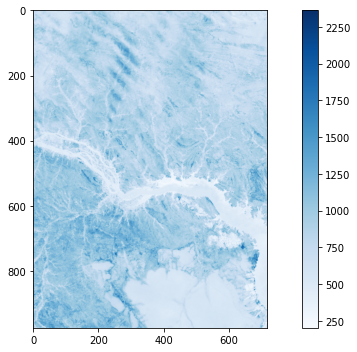

In [70]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Blues', 1000)
plt.imshow(
    blue,
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()

In [3]:
raster = eocube_service.getImages()[2]

In [4]:
raster._afimPointsToCoord(0, 9, 'blue')

(-39.09824184372205, -8.459782237569911)

In [5]:
raster._afimCoordsToPoint(-39.09824184372205, -8.459782237569911, 'red')

(0, 9)

In [81]:
raster._afimPointsToCoord(2837, 4861, 'red')

(-39.103534235177676, -8.460055850121357)

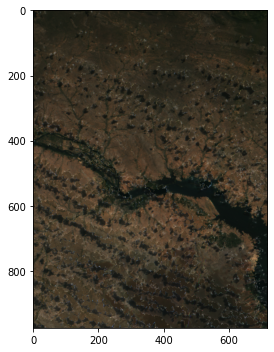

In [71]:
plt.figure(figsize=(10, 5))
plt.imshow(raster.getRGB())
plt.tight_layout()

plt.show()

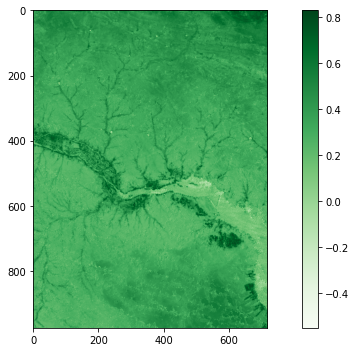

In [62]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Greens', 1000)
plt.imshow(
    raster.getNDVI(),
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()

In [11]:
raster.item['properties']['eo:bands']

[{'name': 'BAND13',
  'common_name': 'blue',
  'description': '',
  'min': 0.0,
  'max': 10000.0,
  'nodata': -9999.0,
  'scale': 0.0001,
  'center_wavelength': 0.485,
  'full_width_half_max': 0.07,
  'data_type': 'int16'},
 {'name': 'BAND14',
  'common_name': 'green',
  'description': '',
  'min': 0.0,
  'max': 10000.0,
  'nodata': -9999.0,
  'scale': 0.0001,
  'center_wavelength': 0.555,
  'full_width_half_max': 0.07,
  'data_type': 'int16'},
 {'name': 'BAND15',
  'common_name': 'red',
  'description': '',
  'min': 0.0,
  'max': 10000.0,
  'nodata': -9999.0,
  'scale': 0.0001,
  'center_wavelength': 0.66,
  'full_width_half_max': 0.06,
  'data_type': 'int16'},
 {'name': 'BAND16',
  'common_name': 'nir',
  'description': '',
  'min': 0.0,
  'max': 10000.0,
  'nodata': -9999.0,
  'scale': 0.0001,
  'center_wavelength': 0.83,
  'full_width_half_max': 0.12,
  'data_type': 'int16'},
 {'name': 'CLEAROB',
  'common_name': 'ClearOb',
  'description': 'Clear Observation Count',
  'min': 1.0,
